In [ ]:
!unzip PlantVillage.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
import matplotlib.pyplot as plt
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
68*32

2176

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 1 1 1 0 1 1 1 1 1 1 1 0 2 0 2 0 1 1 0 0 0 2 0 1 0 1 1 1]


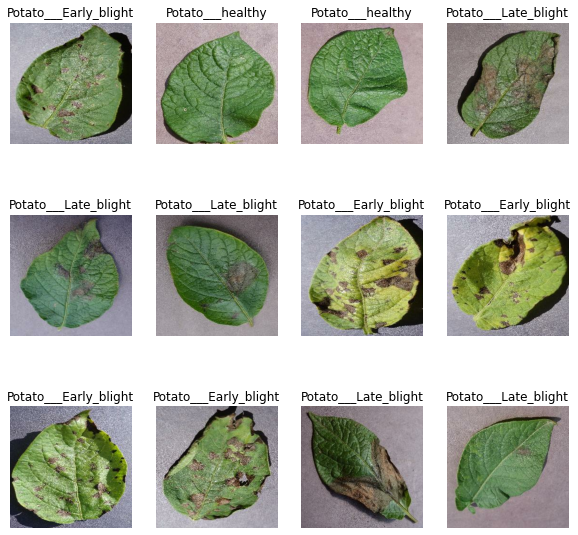

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
8
6


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 50

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 22s 116ms/step - loss: 0.8911 - accuracy: 0.5145 - val_loss: 0.8405 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 4s 70ms/step - loss: 0.6878 - accuracy: 0.6933 - val_loss: 0.7462 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 4s 70ms/step - loss: 0.5568 - accuracy: 0.7836 - val_loss: 0.5780 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 4s 70ms/step - loss: 0.4423 - accuracy: 0.8235 - val_loss: 0.5036 - val_accuracy: 0.7812
Epoch 5/50
54/54 [==============================] - 4s 69ms/step - loss: 0.3342 - accuracy: 0.8547 - val_loss: 0.5260 - val_accuracy: 0.7969
Epoch 6/50
54/54 [==============================] - 4s 69ms/step - loss: 0.3704 - accuracy: 0.8403 - val_loss: 0.4264 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 4s 69ms/step - loss: 0.2921 - accuracy: 0.8883 - val_loss: 0.2097 - val_accuracy: 0.9167
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 34ms/step - loss: 0.0381 - accuracy: 0.9844


In [ ]:
scores

[0.038129232823848724, 0.984375]

In [ ]:
history

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 54}


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

class names :  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Predicting first image : 
First image's actual label :  Potato___Late_blight
Predicted label :  Potato___Late_blight


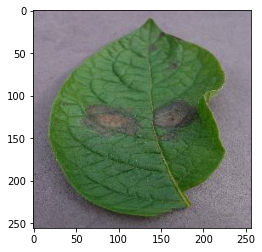

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0]

  print("class names : ", class_names)
  print("Predicting first image : ")
  plt.imshow(first_image)
  print("First image's actual label : ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # create a batch

  prediction = model.predict(img_array)

  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 * (np.max(prediction[0])), 2)
  return predicted_class, confidence

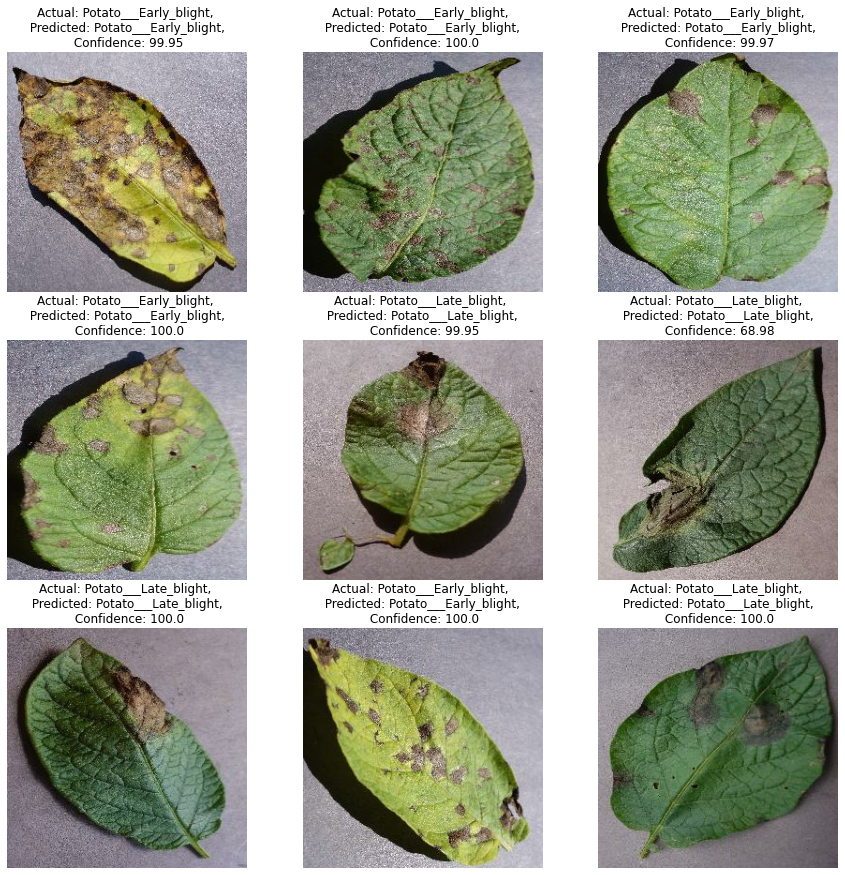

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
    plt.axis("off")


In [ ]:
model_version = 2
model.save(f"{model_version}")

In [ ]:
!zip -r '2.zip' '2'

  adding: 2/ (stored 0%)
  adding: 2/keras_metadata.pb (deflated 94%)
  adding: 2/saved_model.pb (deflated 90%)
  adding: 2/variables/ (stored 0%)
  adding: 2/variables/variables.index (deflated 71%)
  adding: 2/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: 2/assets/ (stored 0%)
